In [79]:
#!/usr/bin/env python
# coding: utf-8
# Author: Nelson Fernandez, Renault Research
# nelson.fernandez-pinto@renault.com

import sys,os
sys.path.append(os.getcwd())

# Imports
from dataset import *
from architectures import *
#from functions import *
from losses import *
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.autograd import Variable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(7)


# Generate dataset
me = MazeExplorer(maze_size=(64,64), nbr_instances=50, 
                  difficulty='easy', nbr_trajectories=2,
                  alpha=17)

# Show deopping percentages
me.get_dopping_percentage()  # point level
me.get_dopping_percentage_trajectories() # trajectory level

# Create CNN model
net = ConvNet().to(device)
print('CNN created...')


# Get set of train/test INDEXES (hacking SKlean train_test_split)
x = np.arange(0, me.len())
train_indexes, test_indexes, _, _ = train_test_split(x, x, 
                                                    test_size=0.33, 
                                                    random_state=7)


# Wrap transforming function to dataset object
t_me = TransformedDataset(me, xy_transform=xy_transform)

# Get training/test subsets
train_me = Subset(t_me, indices=train_indexes)
test_me = Subset(t_me, indices=test_indexes)

# Configure dataloaders
batch_size = 1
num_workers = 4

trainloader = DataLoader(train_me, shuffle=True, 
                          batch_size=batch_size, 
                          num_workers=num_workers, 
                          pin_memory=True)


testloader = DataLoader(test_me, shuffle=True, 
                         batch_size=batch_size, 
                         num_workers=1,
                         pin_memory=True)

print('Train test data loaders created...')

# Init losses
rmse = RMSELoss()
graphic_loss = GraphicLoss()

# Set optimizer (Adam)
optimizer = Adam(net.parameters(), lr=1e-3)
epochs = 200
print('Losses and optimizer created...')


net.train()
print('Init training loop...')

for epoch in range(1, epochs+1):
    iters = 0.0
    total_env = 0.0
    total_rmse = 0.0

    for batch_idx, (data, target, path, goals, expert_flag) in enumerate(trainloader):
        # Convert X, Y to Torch variables
        grid = data   # save numpy version of maze grid

        # Convert input and target to tensors
        data, target = Variable(data), Variable(target)
        data, target = data.to(device).float(), target.to(device).float()
 
        # Set gradient to zero
        optimizer.zero_grad()

        # Get network output
        output = net(data)

        # RMSE loss
        rmse_loss = rmse(output, target)

        # Environmental Loss
        grid = grid[0][0].detach().numpy()
        path = path[0].detach().numpy()
        goals = goals[0].detach().numpy()
        output = output[0].detach().cpu().numpy()

        # Reconstruct predicted grids
        pred_grid = torch.tensor(draw_solution_canvas(grid, output)).double().to(device)
        pred_path = torch.tensor(draw_solution_canvas(path, output)).double().to(device)
        pred_goals = torch.tensor(draw_goals_canvas(grid, output)).double().to(device)

        # Compute graphic losses
        # Wall loss
        wall_loss = graphic_loss(torch.tensor(grid).to(device), pred_grid)
        # Path planning loss 
        path_loss = graphic_loss(torch.tensor(path).to(device), pred_path)
        #path_loss = abs(wall_loss-path_loss)
        # Goals loss
        goal_loss = graphic_loss(torch.tensor(goals).to(device), pred_goals)
        # Non-expert trajectory loss
        env_loss = Variable((wall_loss + path_loss + goal_loss), requires_grad=True)/10 #
        
        # Final loss
        loss = rmse_loss#  + env_loss + rmse_loss
    
        # Backpropagate loss & udpate gradient
        loss.backward()
        optimizer.step()

        # Print information
        iters += loss
        total_env += env_loss
        total_rmse+= rmse_loss

        print('Train Epoch: {} [{}/{} ({:.0f}%)] EnvLoss: {:.6f}  RMSELoss: {:.6f} TotalLoss: {:.6f}'.format(
                    epoch, batch_idx, len(trainloader.dataset),
                    100. * (batch_idx) / len(trainloader), 
                    total_env/len(trainloader), 
                    total_rmse/len(trainloader),
                    iters/len(trainloader)
                    ), 
                    end='\r', flush=True)
    print("")                                 


100%|██████████| 50/50 [00:00<00:00, 722.95it/s]

Creating MazeExplorer dataset of difficulty easy
Using Prims generator
Using shortest path solver



 22%|██▏       | 43/200 [00:00<00:00, 210.88it/s]

Dataset generated... 200 available instances


 58%|█████▊    | 117/200 [00:00<00:00, 567.97it/s]

Estimated dopping percentage (points) =  0.076


100%|██████████| 200/200 [00:00<00:00, 561.51it/s]


Estimated dopping percentage (trajectories)=  1.0
CNN created...
Train test data loaders created...
Losses and optimizer created...
Init training loop...
Train Epoch: 1 [133/134 (99%)] EnvLoss: 26.382843  RMSELoss: 24.711040 TotalLoss: 24.711040
Train Epoch: 2 [133/134 (99%)] EnvLoss: 23.532089  RMSELoss: 22.410742 TotalLoss: 22.410742
Train Epoch: 3 [133/134 (99%)] EnvLoss: 22.787313  RMSELoss: 21.643436 TotalLoss: 21.643436
Train Epoch: 4 [133/134 (99%)] EnvLoss: 23.105972  RMSELoss: 19.835123 TotalLoss: 19.835123
Train Epoch: 5 [133/134 (99%)] EnvLoss: 23.391787  RMSELoss: 17.496445 TotalLoss: 17.496445
Train Epoch: 6 [133/134 (99%)] EnvLoss: 24.940298  RMSELoss: 15.238448 TotalLoss: 15.238448
Train Epoch: 7 [133/134 (99%)] EnvLoss: 25.746265  RMSELoss: 14.740290 TotalLoss: 14.740290
Train Epoch: 8 [133/134 (99%)] EnvLoss: 24.294039  RMSELoss: 13.642619 TotalLoss: 13.642619
Train Epoch: 9 [133/134 (99%)] EnvLoss: 25.773134  RMSELoss: 13.083264 TotalLoss: 13.083264
Train Epoch: 10 [1

Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
   

KeyboardInterrupt: 

In [86]:
net.train()
print('Init training loop...')

for epoch in range(1, epochs+1):
    iters = 0.0
    total_env = 0.0
    total_rmse = 0.0

    for batch_idx, (data, target, path, goals, expert_flag) in enumerate(trainloader):
        # Convert X, Y to Torch variables
        grid = data   # save numpy version of maze grid

        # Convert input and target to tensors
        data, target = Variable(data), Variable(target)
        data, target = data.to(device).float(), target.to(device).float()
 
        # Set gradient to zero
        optimizer.zero_grad()

        # Get network output
        output = net(data)

        # RMSE loss
        rmse_loss = rmse(output, target)

        # Environmental Loss
        grid = grid[0][0].detach().numpy()
        path = path[0].detach().numpy()
        goals = goals[0].detach().numpy()
        output = output[0].detach().cpu().numpy()

        # Reconstruct predicted grids
        pred_grid = torch.tensor(draw_solution_canvas(grid, output)).double().to(device)
        pred_path = torch.tensor(draw_solution_canvas(path, output)).double().to(device)
        pred_goals = torch.tensor(draw_goals_canvas(grid, output)).double().to(device)

        # Compute graphic losses
        # Wall loss
        wall_loss = graphic_loss(torch.tensor(grid).to(device), pred_grid)
        # Path planning loss 
        path_loss = graphic_loss(torch.tensor(path).to(device), pred_path)
        #path_loss = abs(wall_loss-path_loss)
        # Goals loss
        goal_loss = graphic_loss(torch.tensor(goals).to(device), pred_goals)
        # Non-expert trajectory loss
        env_loss = Variable((wall_loss + path_loss + goal_loss), requires_grad=True)/10 #
        
        # Final loss
        loss = rmse_loss#  + env_loss + rmse_loss
    
        # Backpropagate loss & udpate gradient
        loss.backward()
        optimizer.step()

        # Print information
        iters += loss
        total_env += env_loss
        total_rmse+= rmse_loss

        print('Train Epoch: {} [{}/{} ({:.0f}%)] EnvLoss: {:.6f}  RMSELoss: {:.6f} TotalLoss: {:.6f}'.format(
                    epoch, batch_idx, len(trainloader.dataset),
                    100. * (batch_idx) / len(trainloader), 
                    total_env/len(trainloader), 
                    total_rmse/len(trainloader),
                    iters/len(trainloader)
                    ), 
                    end='\r', flush=True)
    print("")                                 


Init training loop...
Train Epoch: 1 [133/134 (99%)] EnvLoss: 23.244024  RMSELoss: 8.439137 TotalLoss: 8.439137
Train Epoch: 2 [133/134 (99%)] EnvLoss: 23.520144  RMSELoss: 8.202918 TotalLoss: 8.202918
Train Epoch: 3 [133/134 (99%)] EnvLoss: 23.076118  RMSELoss: 7.627728 TotalLoss: 7.627728
Train Epoch: 4 [133/134 (99%)] EnvLoss: 22.102987  RMSELoss: 7.536833 TotalLoss: 7.536833
Train Epoch: 5 [133/134 (99%)] EnvLoss: 22.449251  RMSELoss: 7.920945 TotalLoss: 7.920945
Train Epoch: 6 [133/134 (99%)] EnvLoss: 23.558207  RMSELoss: 7.721991 TotalLoss: 7.721991
Train Epoch: 7 [133/134 (99%)] EnvLoss: 23.395525  RMSELoss: 7.543899 TotalLoss: 7.543899
Train Epoch: 8 [133/134 (99%)] EnvLoss: 23.905973  RMSELoss: 7.626787 TotalLoss: 7.626787
Train Epoch: 9 [133/134 (99%)] EnvLoss: 24.068659  RMSELoss: 7.719342 TotalLoss: 7.719342


Traceback (most recent call last):
  File "/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
Traceback (most recent call last):
  File "/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaco

KeyboardInterrupt: 

In [87]:
net.eval()

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (drop_out): Dropout(p=0.5)
  (fc1): Linear(in_features=16384, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=100, bias=True)
)

In [102]:

for i, (data, target, path, goals, expert_flag) in enumerate(testloader):
    # Convert input and target to tensors
    data, target = Variable(data), Variable(target)
    data, target = data.to(device).float(), target.to(device).float()
    # Get network output
    output = net(data)

    # RMSE loss
    rmse_loss = rmse(output, target)
    print(rmse_loss)
    
    #print(i)
    if i == 9:
        break


tensor(5.7891, grad_fn=<SqrtBackward>)
tensor(4.9636, grad_fn=<SqrtBackward>)
tensor(4.9669, grad_fn=<SqrtBackward>)
tensor(6.9963, grad_fn=<SqrtBackward>)
tensor(8.4008, grad_fn=<SqrtBackward>)
tensor(2.4058, grad_fn=<SqrtBackward>)
tensor(2.2934, grad_fn=<SqrtBackward>)
tensor(8.7058, grad_fn=<SqrtBackward>)
tensor(7.5401, grad_fn=<SqrtBackward>)
tensor(3.6444, grad_fn=<SqrtBackward>)


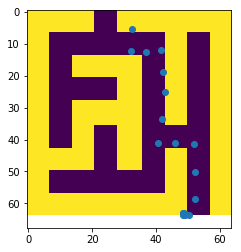

In [103]:
plt.imshow(data[0][0])#output[:,:].detach().numpy())
plt.scatter(output[:,:,1].detach().numpy(), output[:,:,0].detach().numpy())

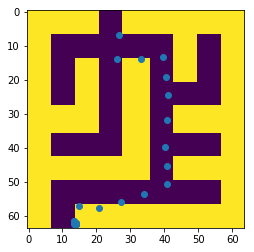

In [101]:
plt.imshow(data[0][0])#output[:,:].detach().numpy())
plt.scatter(output[:,:,1].detach().numpy(), output[:,:,0].detach().numpy())

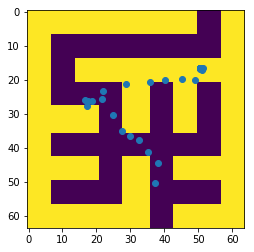

In [99]:
plt.imshow(data[0][0])#output[:,:].detach().numpy())
plt.scatter(output[:,:,1].detach().numpy(), output[:,:,0].detach().numpy())

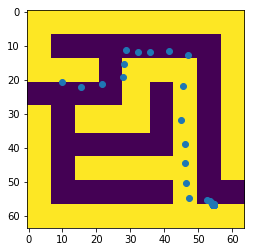

In [95]:
plt.imshow(data[0][0])#output[:,:].detach().numpy())
plt.scatter(output[:,:,1].detach().numpy(), output[:,:,0].detach().numpy())

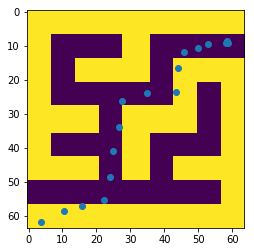

In [93]:
plt.imshow(data[0][0])#output[:,:].detach().numpy())
plt.scatter(output[:,:,1].detach().numpy(), output[:,:,0].detach().numpy())